In [143]:
library(IRdisplay)
library(Cairo)

library(ggplot2)
library(dplyr)
library(ggrepel)

In [144]:
options(repr.plot.width=8, repr.plot.height=8, repr.plot.res=200)

In [145]:
result_path = '/s/project/promoter_prediction/sex_analysis/isoform_proportions'

In [146]:
rds_files = list.files(path = result_path, pattern = "\\.RDS$", full.names = TRUE)

In [147]:
length(rds_files)

[1] 649

In [148]:
extract_gene_name <- function(file) {
  # Extract the base name of the file (without path)
  file_base <- basename(file)
  # Use regular expression to extract the gene name (assuming the gene name is before the first dot)
  gene_name <- sub(".RDS$", "", file_base)
  return(gene_name)
}

In [149]:
names(rds_files) <- sapply(rds_files, extract_gene_name)

In [150]:
extract_values <- function(file) {
    rds_data <- readRDS(file)
    anovaRes <- rds_data$anovaRes
    modelCoef <- rds_data$sexModelCoef$gamma$gamma[['sexMale']]
    return(list(pvalue=anovaRes$`Pr(>Chi)`[2], signedMaxCoef=modelCoef))
}

In [151]:
# extract_values <- function(file) {
#     rds_data <- readRDS(file)
#     anovaRes <- rds_data$anovaRes
#     modelCoefs <- sapply(rds_data$sexModelCoef$beta, function(x) x[["sexMale"]])
#     signedMaxCoef <- modelCoefs[which.max(abs(modelCoefs))]
#     transcript = sub("proportion_", "", names(signedMaxCoef))
#     signedMaxCoef <- unlist(signedMaxCoef)
#     return(list(pvalue=anovaRes$`Pr(>Chi)`[2], signedMaxCoef=signedMaxCoef, transcript=transcript))
# }

In [152]:
readRDS(rds_files[1])$sexModelCoef$gamma$gamma[['sexMale']]

[1] -0.066468

In [153]:
df = bind_rows(lapply(rds_files, extract_values), .id = "gene")

In [154]:
df = df[df$pvalue != 0,]
head(df)

gene,pvalue,signedMaxCoef
<chr>,<dbl>,<dbl>
ENSG00000000457,0.001906488,-0.0664679996
ENSG00000000460,0.899762203,-0.0027641151
ENSG00000000938,0.186983908,-0.0297833240
ENSG00000000971,0.167339514,0.0469396651
ENSG00000001084,0.990363969,-0.0002722275
ENSG00000001167,0.019909567,-0.0865091941


In [155]:
top5_genes

gene,pvalue,signedMaxCoef,adjusted_pvalue,negLog10Pvalue
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000144034,3.501508e-29,-0.3905825,1.792772e-26,25.74647
ENSG00000114270,1.827300e-18,-0.1599224,4.677888e-16,15.32995
ENSG00000143674,1.387527e-16,-0.3068209,2.368047e-14,13.62561
ENSG00000100138,2.967114e-15,-0.2656516,3.797906e-13,12.42046
ENSG00000106443,1.005478e-14,0.2527034,1.029610e-12,11.98733


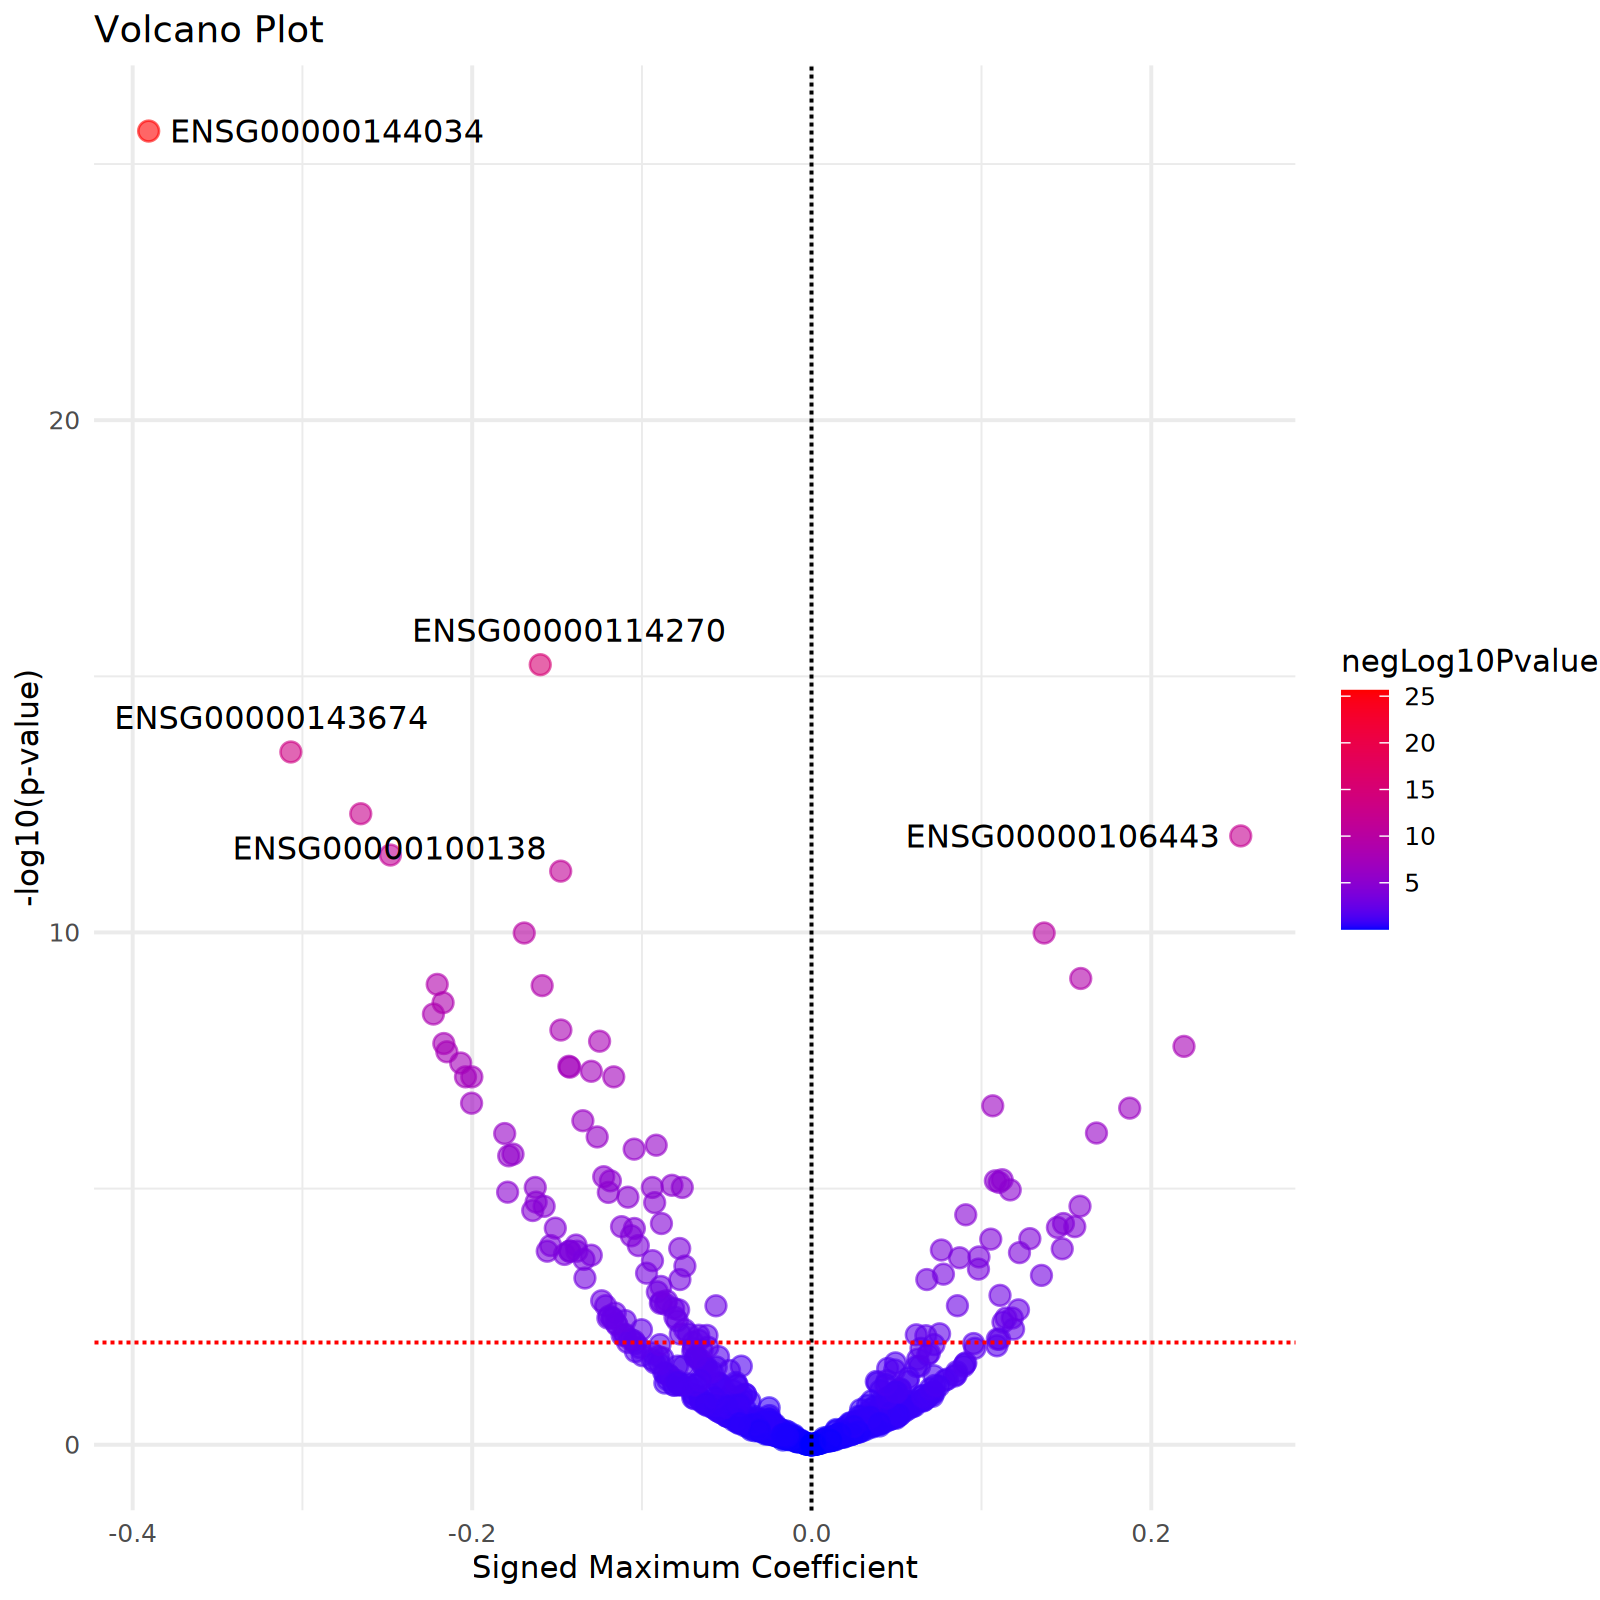

In [156]:
# Sort dataframe by pvalue and select the top 5 genes
df$adjusted_pvalue <- p.adjust(df$pvalue, method = "BH")
df$negLog10Pvalue <- -log10(df$adjusted_pvalue)
top5_genes <- df[order(df$adjusted_pvalue), ][1:5, ]

# Create the volcano plot
ggplot(df, aes(x = `signedMaxCoef`, y = `negLog10Pvalue`)) +
  geom_point(alpha = 0.6, size = 3, aes(color = `negLog10Pvalue`)) +  # Scatter plot points
  geom_vline(xintercept = 0, linetype = "dashed") +  # Vertical line at x = 0
  geom_hline(yintercept = -log10(0.01), linetype = "dashed", color = "red") +  # Horizontal line for p = 0.01
  labs(title = "Volcano Plot", x = "Signed Maximum Coefficient", y = "-log10(p-value)") +
  theme_minimal() +  # Minimal theme
  scale_color_gradient(low = "blue", high = "red") +  # Color gradient
  geom_text_repel(data = top5_genes, aes(label = gene), size = 4, box.padding = 0.5)  # Add labels for top 5 genes